Total text length: 214451
Train text length: 64335
Validation text length: 21445
Test text length: 128671

Training RNN with hidden size: 4
Hidden size 4, Final Test accuracy: 5.65%

Training RNN with hidden size: 8
Hidden size 8, Final Test accuracy: 3.80%


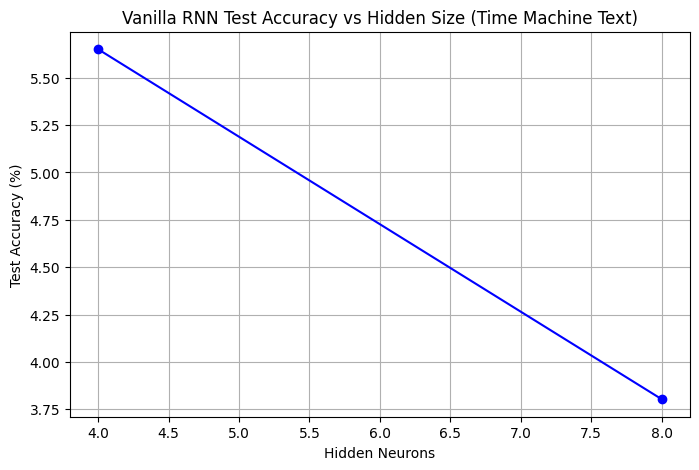

In [5]:
# ---------------------------------------------------------------------
# ******* RNN for Next Character prediction  ************
# A vanilla RNN is used for the proboem of next character prediction
# using the characters form "The Time Machine" book.
# The code tries a different number of hidden neurons.
# Training  uses a validation early-stopping scheme in a 30-10-60 split
# Length sequence = 20 and predicction of next character task
# ReLu activations are used and Dropout is implemented
# Rest of hyperparameters can be modified for improved results
# ---------------------------------------------------------------------
#!pip install d2l==1.0.0a0
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load text from file
# ----------------------------
file_path = "/content/timemachine.txt"
with open(file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()
full_text = raw_text.lower()

# ----------------------------
# Text Preprocessing: ASCII, no capitals, no punctuation, 26 letters + space + unk
# ----------------------------
allowed_chars_set = set('abcdefghijklmnopqrstuvwxyz ')
unk_token = '<unk>'

cleaned_full_text = []
for char in full_text:
    if char in allowed_chars_set:
        cleaned_full_text.append(char)
    else:
        cleaned_full_text.append(unk_token)
full_text = "".join(cleaned_full_text)

# -----------------------------------------------------
# Split percentages cannot be modified for the challenge
# Split text into train, val, test (30%, 10%, 60%)
# -----------------------------------------------------
total_length = len(full_text)
train_split_idx = int(0.3 * total_length)
val_split_idx = int(0.1 * total_length) + train_split_idx

train_text = full_text[:train_split_idx]
val_text = full_text[train_split_idx:val_split_idx]
test_text = full_text[val_split_idx:]

print(f"Total text length: {total_length}")
print(f"Train text length: {len(train_text)}")
print(f"Validation text length: {len(val_text)}")
print(f"Test text length: {len(test_text)}")

# ----------------------------
# Character mapping (re-created after cleaning)
# ----------------------------
chars = sorted(list(set(full_text))) # This will now only contain allowed_chars and unk_token
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}

# ---------------------------------------------------------
# Hyperparameters that cannot be modified for the challenge
# ---------------------------------------------------------
seq_length = 20
future_steps = 1
# ---------------------------------------------------------
# Hyperparameters that should be modified for the challenge
batch_size = 32 #def:32
num_epochs = 10 # def 10
learning_rate = 0.01   # def: 0.01
patience = 10 #def 10
hidden_sizes = [2,4,8,16,32,64] # Hidden size to be tested (def: [2,4,8,16,32,64])
clip_value = 1.0  # gradient clipping def: 1.0
dropout_rate = 0.5 # Dropout rate added def:0.5
# ---------------------------------------------------------


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Dataset preparation
# ----------------------------
def create_sequences(text, seq_length, future_steps):
    X, Y = [], []
    for i in range(len(text) - seq_length - future_steps):
        seq = text[i:i+seq_length]
        target = text[i+seq_length:i+seq_length+future_steps]
        X.append([char2idx[ch] for ch in seq])
        Y.append([char2idx[ch] for ch in target])
    return np.array(X), np.array(Y)

X_train_seq, Y_train_seq = create_sequences(train_text, seq_length, future_steps)
X_val_seq, Y_val_seq = create_sequences(val_text, seq_length, future_steps)
X_test_seq, Y_test_seq = create_sequences(test_text, seq_length, future_steps)

X_train = torch.tensor(X_train_seq, dtype=torch.long).to(device)
Y_train = torch.tensor(Y_train_seq, dtype=torch.long).to(device)
X_val = torch.tensor(X_val_seq, dtype=torch.long).to(device)
Y_val = torch.tensor(Y_val_seq, dtype=torch.long).to(device)
X_test_final = torch.tensor(X_test_seq, dtype=torch.long).to(device)
Y_test_final = torch.tensor(Y_test_seq, dtype=torch.long).to(device)

# ----------------------------
# Vanilla RNN model
# ----------------------------
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, future_steps, dropout_rate=0.0):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.future_steps = future_steps
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.dropout = nn.Dropout(dropout_rate) # Dropout layer added
        self.fc = nn.Linear(hidden_size, future_steps * vocab_size)
        self.init_weights()

    def init_weights(self):
        # Xavier initialization is the default for initial weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # last time step
        out = self.dropout(out) # Dropout applied here
        out = self.fc(out)
        out = out.view(-1, self.future_steps, vocab_size)
        return out

# ----------------------------
# Training loop over hidden sizes
# ----------------------------
test_accuracies = []

for hidden_size in hidden_sizes:
    print(f"\nTraining RNN with hidden size: {hidden_size}")
    rnn = VanillaRNN(vocab_size, hidden_size, future_steps, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        rnn.train()
        optimizer.zero_grad()
        output = rnn(X_train)
        loss = sum(criterion(output[:, t, :], Y_train[:, t]) for t in range(future_steps))
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip_value)
        optimizer.step()

        # Validation
        rnn.eval()
        with torch.no_grad():
            val_output = rnn(X_val)
            val_loss = sum(criterion(val_output[:, t, :], Y_val[:, t]) for t in range(future_steps))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(rnn.state_dict(), f"best_rnn_TimeMachine_{hidden_size}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Final Test accuracy
    rnn.load_state_dict(torch.load(f"best_rnn_TimeMachine_{hidden_size}.pth"))
    rnn.eval()
    with torch.no_grad():
        output = rnn(X_test_final)
        preds = output.argmax(dim=2)
        acc = (preds == Y_test_final).float().mean().item()
        test_accuracies.append(acc)
        print(f"Hidden size {hidden_size}, Final Test accuracy: {acc*100:.2f}%")

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(hidden_sizes, [a*100 for a in test_accuracies], marker='o', color='blue')
plt.xlabel("Hidden Neurons")
plt.ylabel("Test Accuracy (%)")
plt.title("Vanilla RNN Test Accuracy vs Hidden Size (Time Machine Text)")
plt.grid(True)
plt.show()